In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from diGP.preprocessing import (readHCP,
                                readSPARC,
                                averageb0Volumes,
                                createBrainMaskFromb0Data,
                                replaceNegativeData,
                                normalize_data)
from diGP.dataManipulations import (DataHandler,
                                    log_q_squared,
                                    generateCoordinates)
from diGP.generateSyntheticData import combineCoordinatesAndqVecs

%matplotlib inline
sns.set_style('dark')

 C:\Users\sesjojen\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\filter\__init__.py:6: skimage_deprecation:The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.


In [4]:
dataPath = {'HCP_1007': 'C:\\Users\\sesjojen\\Documents\\Data\\HumanConnectomeProject\\mgh_1007\\diff\\preproc',
            'SPARC_20': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_20_nifti',
            'SPARC_30': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_30_nifti',
            'SPARC_60': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\gradient_60_nifti',
            'SPARC_GS': 'C:\\Users\\sesjojen\\Documents\\Data\\SPARC\\nifti\\goldstandard_nifti'}

def read(path_dict, data_source):
    if data_source[0:3] == 'HCP':
        return readHCP(path_dict[data_source])
    elif data_source[0:5] == 'SPARC':
        return readSPARC(path_dict[data_source])
    else:
        raise Exception('Unknown data source.')

In [5]:
source = 'SPARC_20'
gtab, data, voxelSize = read(dataPath, source)
print(gtab.info)

B-values shape (61,)
         min 0.000000 
         max 3000.000000 
B-vectors shape (61, 3)
         min -0.974619 
         max 0.998757 
None


In [6]:
data = replaceNegativeData(data, gtab)

b0 = averageb0Volumes(data, gtab)
if source[0:5] == 'SPARC':
    mask = np.ones_like(b0)
else:
    mask = createBrainMaskFromb0Data(b0)

data = normalize_data(data, b0, mask)

Compare with spatial interpolation in striped pattern.

In [7]:
mid_z = np.round(data.shape[2]/2).astype(int)
handler = DataHandler(gtab, data[::2, :, mid_z, :], voxelSize=(2*voxelSize[0], voxelSize[1]),
                      image_origin=voxelSize[0:2]*np.array([0, 0]), qMagnitudeTransform=log_q_squared)

handlerPred = DataHandler(gtab, data[1::2, :, mid_z, :], voxelSize=(2*voxelSize[0], voxelSize[1]),
                          image_origin=voxelSize[0:2]*np.array([1, 0]), qMagnitudeTransform=log_q_squared)

In [8]:
spatialLengthScale = 5
bValLengthScale = 3

kernel = (GPy.kern.RBF(input_dim=1, active_dims=[0],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.RBF(input_dim=1, active_dims=[1],
                       variance=1,
                       lengthscale=spatialLengthScale) *
          GPy.kern.Matern52(input_dim=1, active_dims=[2],
                            variance=1,
                            lengthscale=bValLengthScale) *
          GPy.kern.LegendrePolynomial(
             input_dim=3,
             coefficients=np.array((2, 0.5, 0.05)),
             orders=(0, 2, 4),
             active_dims=(3, 4, 5)))

kernel.parts[0].variance.fix(value=1)
kernel.parts[1].variance.fix(value=1)
kernel.parts[2].variance.fix(value=1)

array([0])

In [9]:
grid_dims = [[0], [1], [2, 3, 4, 5]]

model = GPy.models.GPRegressionGrid(handler.X, handler.y, kernel, grid_dims=grid_dims)        

In [10]:
model.optimize(messages=True)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [11]:
print(model)
print("\nLegendre coefficients: \n{}".format(model.mul.LegendrePolynomial.coefficients))


Name : GP Grid regression
Objective : -6110.233270001402
Number of Parameters : 10
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_Grid_regression.                  |             value  |  constraints  |  priors
  mul.rbf.variance                     |               1.0  |   +ve fixed   |        
  mul.rbf.lengthscale                  |     4.08146709665  |      +ve      |        
  mul.rbf_1.variance                   |               1.0  |   +ve fixed   |        
  mul.rbf_1.lengthscale                |     2.61288965205  |      +ve      |        
  mul.Mat52.variance                   |               1.0  |   +ve fixed   |        
  mul.Mat52.lengthscale                |      1.4090104678  |      +ve      |        
  mul.LegendrePolynomial.coefficients  |              (3,)  |      +ve      |        
  Gaussian_noise.variance              |  0.00603813265475  |      +ve      |        

Legendre coefficients: 
  index  |  GP_Grid_regression.mul.LegendrePolynomia

In [12]:
#mu = model.predict_noiseless(handlerPred.X, compute_var=False)
mu, var = model.predict_noiseless(handlerPred.X, compute_var=True)

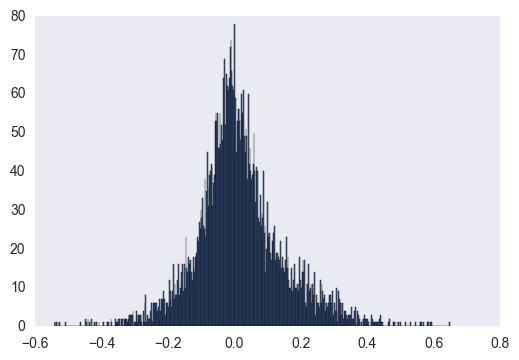

In [13]:
plt.hist(handlerPred.y-mu, bins=500);

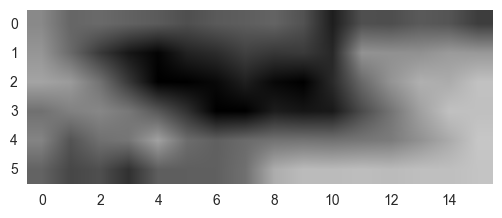

In [19]:
y_slice = handler.y.reshape(handler.originalShape)[:, :, 1]
mu_slice = mu.reshape(handlerPred.originalShape)[:, :, 1]
#plt.imshow(y_slice, vmin=0, vmax=1)
plt.imshow(mu_slice, vmin=0, vmax=1)

In [16]:
sz=data.shape
combined = np.zeros((sz[0], sz[1], sz[3]))

y_idx = (handler.X_coordinates/ voxelSize[0:2]).astype(int)
mu_idx = (handlerPred.X_coordinates / voxelSize[0:2]).astype(int)

combined[y_idx[:, 0], y_idx[:, 1], :] = handler.y.reshape(np.prod(handler.originalShape[0:-1]), -1)
combined[mu_idx[:, 0], mu_idx[:, 1], :] = mu.reshape(np.prod(handlerPred.originalShape[0:-1]), -1)

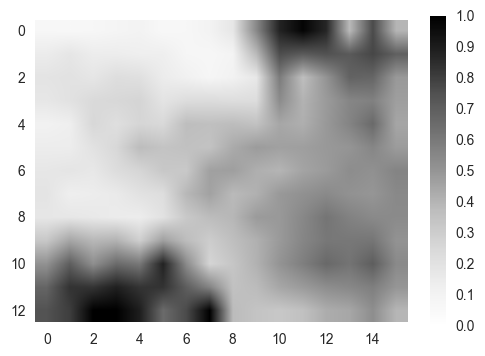

In [17]:
fig, ax = plt.subplots()
cax = ax.imshow(combined[:, :, 30], vmin=0, vmax=1)
fig.colorbar(cax)